## Hourly Time Series Forecasting with XGBoost
The aim of this notebook is to predict hourly power consumption based on data from PJM using time series forecasting with XGBoost.

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

XGBoost is a specific implementation of a gradient boosted tree that is a simple to implement and fast in terms of computing speed. Boosted trees are essentially an ensemble of decision trees which are fit sequentially so that each new tree makes up for the errors of the previously existing set of trees. The model is "boosted" by focusing new additions on correcting the residual errors of the last version of the model.

Gradient Boosted Machiens (GBM) works similiar to gradient descent except that instead of taking a step in the gradient direction, you take an approximate step in the gradient direction by training a model to predict the gradient given the data. (For decision trees making a step in the gradient direction is not well defined as the models are piecewise constant). It's essentially approximate GD in function space. Function space is approximated by the prediction of the model on the data points.

This notebook uses data from the following [link](https://www.kaggle.com/robikscube/hourly-energy-consumption) and follows the example of [Rob Muller.](https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost)

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
#plt.style.use(fivethirtyeight)

PJME stands for the PJM data of the east region from 2002-2018.

In [4]:
pjme = pd.read_csv(r'C:\Users\vinhe\Code\Projects\hourly-energy-consumption-forecasting\data\PJME_hourly.csv', index_col=[0], parse_dates=[0])

In [5]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


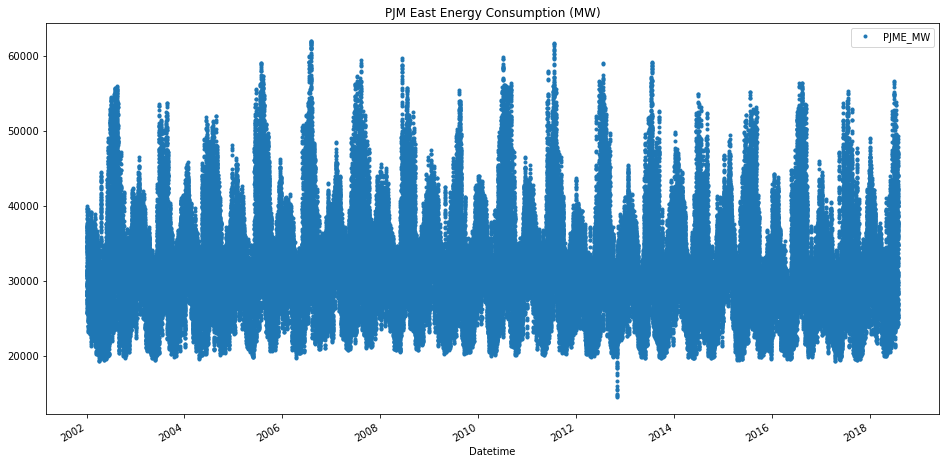

In [9]:
pjme.plot(style='.', figsize=(16,8), title='PJM East Energy Consumption (MW)')

## Train/Test Split
Data after 2015 will be cut off and used as validation set.

In [7]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

Visualisation of the train/test split of data:

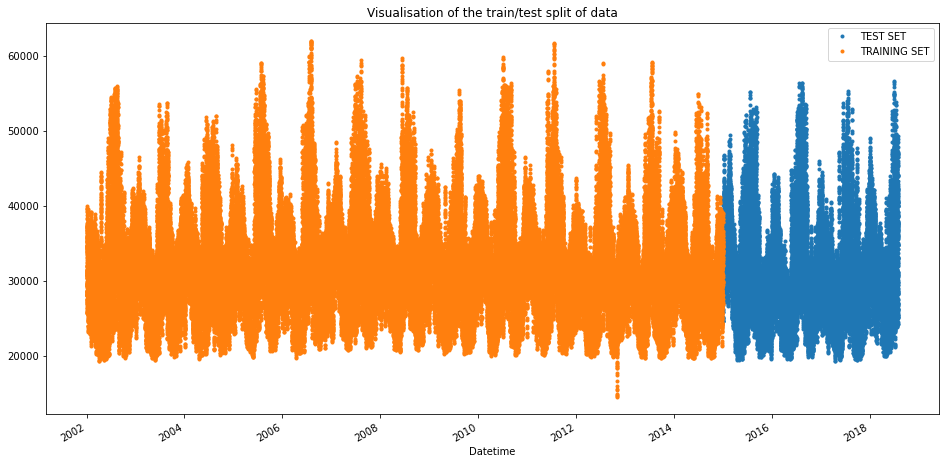

In [13]:
pjme_test.rename(columns={'PJME_MW': 'TEST SET'}).join(pjme_train.rename(columns={'PJME_MW':'TRAINING SET'}), how='outer').plot(figsize=(16,8), title='Visualisation of the train/test split of data', style='.')

## Create Time Series Features

In [14]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear']]
    
    if label:
        y = df[label]
        return X, y
    return X

In [15]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

## Create XGBoost Model

In [16]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Feature Importance
Feature importance is a useful way to rank which features are most valuable for prediction. This metrics simply sums up the number of times each feature is split on.

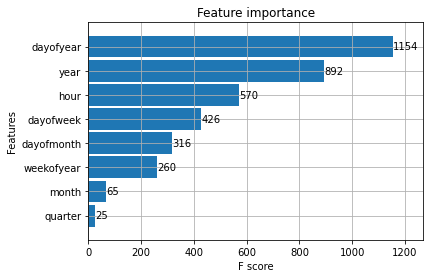

In [17]:
plot_importance(reg, height=0.9)

This shows that day of year is the most commonly used feature to split trees, followed by year and hour.

## Forecast on Test Set

In [18]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

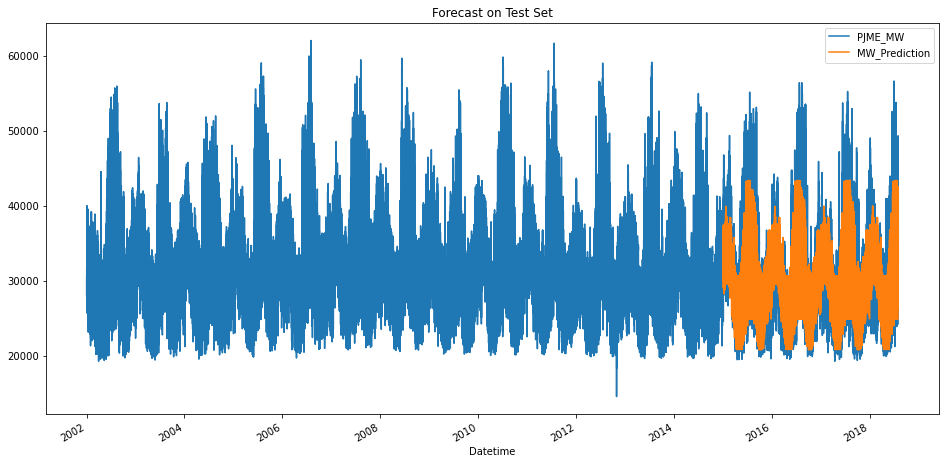

In [20]:
pjme_all[['PJME_MW', 'MW_Prediction']].plot(figsize=(16,8), title='Forecast on Test Set')

### Visualisation of first month of prediction (January 2015)

Text(0.5, 0.98, 'January 2015 Forecast Energy Consumption (MW) vs Actual Energy Consumption (MW)')

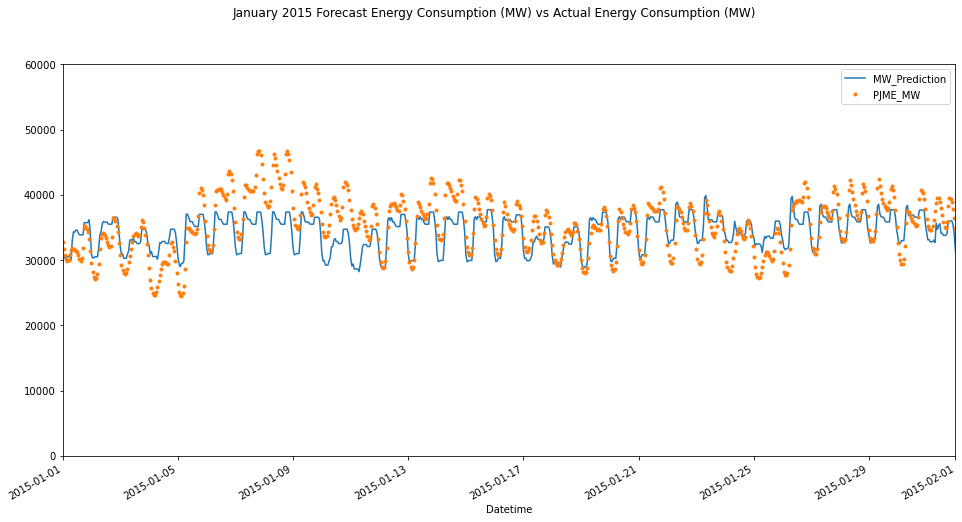

In [30]:
# Plot the forecast with the actual figures
f, ax = plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(16)
pjme_all[['MW_Prediction', 'PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plt.suptitle('January 2015 Forecast Energy Consumption (MW) vs Actual Energy Consumption (MW)')

### Visualisation of first week of prediction (January 2015)

Text(0.5, 0.98, 'First Week of January Forecast Energy Consumption (MW) vs Actual Energy Consumption (MW)')

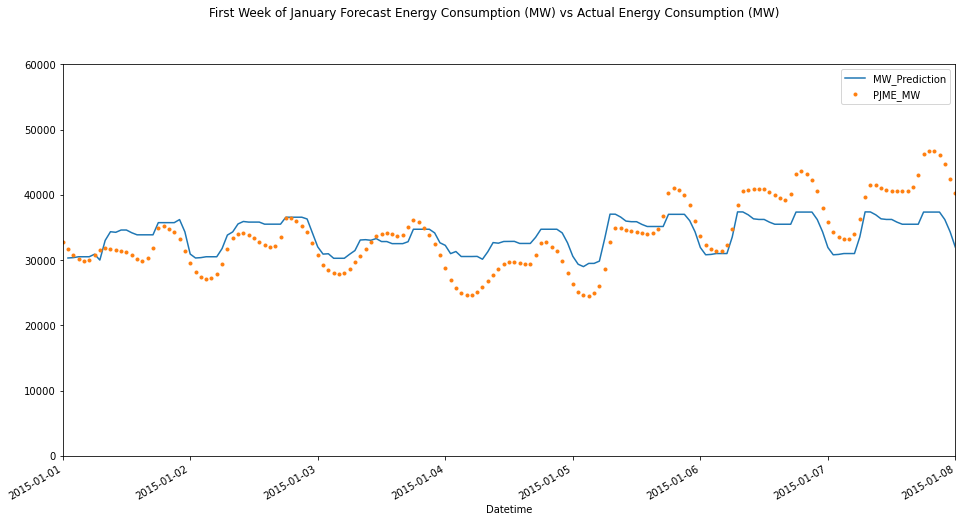

In [31]:
# Plot the forecast with the actual figures
f, ax = plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(16)
pjme_all[['MW_Prediction', 'PJME_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plt.suptitle('First Week of January Forecast Energy Consumption (MW) vs Actual Energy Consumption (MW)')

## Error Metrics on Test Set

In [37]:
mse = mean_squared_error(y_true=pjme_test['PJME_MW'],
                  y_pred=pjme_test['MW_Prediction'])

print('The mean squared error is', round(mse,0))

The mean squared error is 13960913.0


In [40]:
mae = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                    y_pred=pjme_test['MW_Prediction'])

print('The mean absolute error is', round(mae, 0))

The mean absolute error is 2757.0


In [41]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculates MAPE given y_true and y_pred
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [43]:
mape = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                                      y_pred=pjme_test['MW_Prediction'])

print('The mean absolute percentage error is', round(mape,1),'%')

The mean absolute percentage error is 8.5 %


## Analyse Worst and Best Day Predictions

In [46]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year', 'month', 'dayofmonth']).mean()[['PJME_MW', 'MW_Prediction', 'error', 'abs_error']]

In [47]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(15)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   36429.839844 -8029.882894  8029.882894
2017 2     24          26445.083333   34425.839844 -7980.756429  7980.756429
           25          24344.458333   31702.664062 -7358.206299  7358.206299
     9     4           26552.416667   33609.351562 -7056.935954  7056.935954
     2     20          27070.583333   33860.238281 -6789.655355  6789.655355
     9     1           27280.500000   33966.476562 -6685.977132  6685.977132
     2     19          24555.500000   31178.527344 -6623.027913  6623.027913
2018 2     21          27572.500000   34057.515625 -6485.015869  6485.015869
2017 3     1           27574.125000   34057.515625 -6483.390869  6483.390869
     2     23          27663.416667   34141.667969 -6478.251872  6478.251872
2016 3     25          25174.416667   31594.564453 -6420.147705  6420.147705
2015 12    25          24466.083333   30873.314453 -6407.231364  6407.231364
2016 6     9           27318.083333   33692.609375 -6374.525146  6374.525146
2017 2     8           28523.833333   34826.414062 -6302.582601  6302.582601
     5     29          24528.416667   30788.685547 -6260.269043  6260.269043

Many of the over forecasted days occur on holidays, for example:
- #1 worst day (4th July 2016) is Independence Day
- #3 worst day (25th December 2015) is Christmas
- #5 worst day (4th July 2016) is Independence Day

One future way to improve the model is to add a holiday feature.

In [49]:
# worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   31390.199219  13795.634766  13795.634766
           14          44427.333333   31185.371094  13241.961751  13241.961751
     9     10          40996.166667   27985.250000  13010.917562  13010.917562
           9           43836.958333   32078.492188  11758.466064  11758.466064
     8     12          45724.708333   34440.406250  11284.303223  11284.303223
2018 1     6           43565.750000   32572.080078  10993.670003  10993.670003
2015 2     20          44694.041667   33874.218750  10819.821045  10819.821045
2017 5     19          38032.583333   27777.609375  10254.974935  10254.974935
2015 2     16          43949.500000   33860.238281  10089.261312  10089.261312
     9     9           42266.875000   32276.361328   9990.514160   9990.514160

In [50]:
# best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2018 5     13          24001.500000   24218.675781 -217.174967  338.625000
2016 4     4           28944.125000   28569.861328  374.264323  429.709147
     9     28          27910.833333   28260.042969 -349.209961  479.797038
2015 10    3           25534.875000   25807.496094 -272.620850  485.690348
     9     22          28185.875000   28314.941406 -129.067383  496.139974
     4     20          27369.000000   27608.917969 -239.918376  503.891357
2018 5     17          28035.208333   28513.269531 -478.060872  515.793783
2016 10    2           24659.083333   25016.308594 -357.224284  515.855794
2015 9     21          27988.041667   28057.207031  -69.165365  517.167806
2017 5     13          24752.333333   24626.263672  126.069092  531.713135

Mid May and late September seem to be good times for more accurate predictions.

## Plotting worst & best predicted days

Text(0.5, 0.98, 'Worst Predicted Day (13/08/16) - Forecast vs Actual Energy Consumption (MW)')

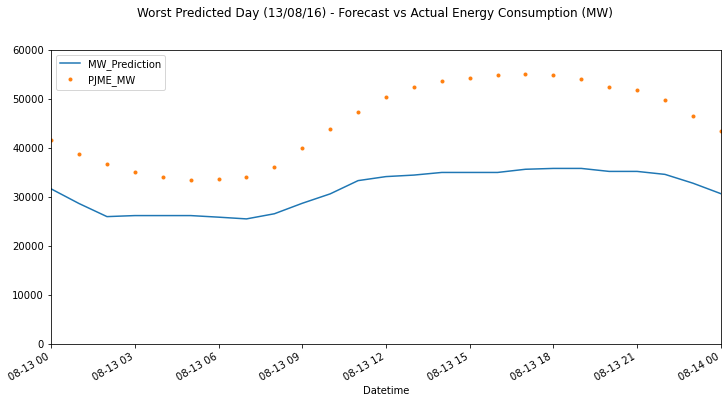

In [58]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(12)
pjme_all[['MW_Prediction', 'PJME_MW']].plot(ax=ax,
                                           style=['-', '.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plt.suptitle('Worst Predicted Day (13/08/16) - Forecast vs Actual Energy Consumption (MW)')

Text(0.5, 0.98, 'Best Predicted Day (13/05/18) - Forecast vs Actual Energy Consumption (MW)')

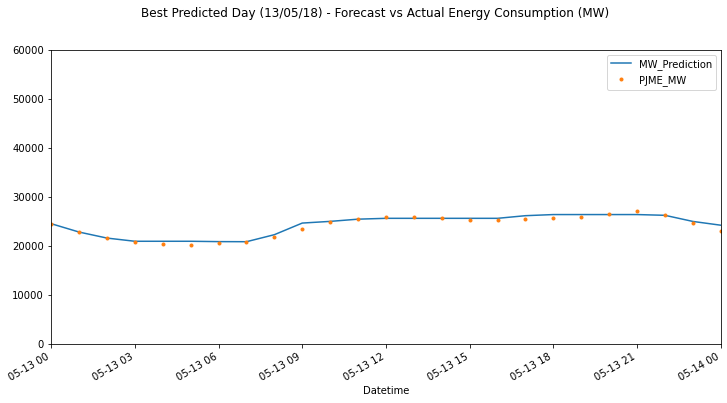

In [57]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(12)
pjme_all[['MW_Prediction', 'PJME_MW']].plot(ax=ax,
                                           style=['-', '.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='05-13-2018', upper='05-14-2018')
plt.suptitle('Best Predicted Day (13/05/18) - Forecast vs Actual Energy Consumption (MW)')

## Future Areas of Improvements
- Add holiday indicator
- Add external weather source
- Add lag variables